In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocess import Pool, cpu_count

# Case I - Bar do Adriano

Com um fim (?) da pandemia, o **Bar do Adriano** está fazendo muito sucesso. O seu dono, Adriano, está preocupado com as **filas que estão se formando fora do bar**, e com a **perda de clientes** (muitos desistem de esperar na fila).

O bar é *bem simples*, contendo apenas um **balcão com 10 lugares**. Devido as leis de zoneamento da região, Adriano não pode instalar mesas fora do bar, e, portanto, está buscando alternativas. No entanto ele **teme que o aumento no número de clientes não seja suficiente para balancear o aumento de custo operacional e investimento necessário para expansão do balcão**.

**Você foi contrado para estimar quantos clientes diferentes tamanhos de balcão poderiam atender**! Infelizmente, **Adriano não possui NENHUM dado sobre a operação de seu bar**, apenas algumas medições simples:

1. *O bar fica aberto 3h por noite (vizinhos chatos...)*;
1. *Em média, 50 clientes entram na fila por hora*;
1. *Em média, um cliente fica 15m na fila antes de desistir*;
1. *Uma vez sentados, clientes ficam, em média, 30m no balcão*;
1. *O bar atualmente tem 10 bancos mas Adriano tem a possibilidade de investir e aumentar este número para 30*.

**Conhecendo os rudimentos da Probabilidade, você decide utilizar simulação de Monte Carlo para construir esta estimativa!**

In [2]:
50/60

0.8333333333333334

In [3]:
NUM_MINUTOS = 180
MEDIA_CHEGADA = 50/60
TEMPO_DESISTE = 15
TEMPO_ESTADIA = 30
TAMANHO_BALCAO = 10

balcao_bar = []
fila = []

p_desiste_minuto = 1/TEMPO_DESISTE

rv_chegada = sp.stats.poisson(MEDIA_CHEGADA)
rv_tempo_balcao = sp.stats.expon(TEMPO_ESTADIA)
rv_abandono = sp.stats.bernoulli(p_desiste_minuto)

n_cliente = 0
n_abandono = 0
n_cliente_atendido = 0
tx_ocup = []

for i in range(NUM_MINUTOS):
    # MODELANDO CHEGADA DE CLIENTES
    num_clientes = rv_chegada.rvs()
    if num_clientes > 0:
        for cliente in range(num_clientes):
            n_cliente += 1
            tempo_estadia = int(rv_tempo_balcao.rvs())
            minuto_saida = i + tempo_estadia
            fila.append((n_cliente, i, minuto_saida))

    # MODELANDO CLIENTES SAINDO DA FILA P/ BALCAO
    while len(balcao_bar) < TAMANHO_BALCAO and len(fila) > 0:
        cliente_atendido = fila.pop(0)
        balcao_bar.append(cliente_atendido)
        
    # MODELANDO SAIDA DE CLIENTES DO BALCAO
    if len(balcao_bar) > 0:
        lista_saida = []
        
        for cliente in balcao_bar:
            if i >= cliente[2]:
                lista_saida.append(cliente)
                
        for cliente in lista_saida:
            n_cliente_atendido += 1
            balcao_bar.pop(balcao_bar.index(cliente))

    # MODELANDO DESISTENCIA DA FILA
    if len(fila) > 0:
        lista_desiste = []
        for cliente in fila:
            
            if rv_abandono.rvs() == 1:
                lista_desiste.append(cliente)
                
        for cliente in lista_desiste:
            n_abandono += 1
            fila.pop(fila.index(cliente))

    tx_ocup.append(len(balcao_bar)/TAMANHO_BALCAO)


In [6]:
n_cliente_atendido

68

In [8]:
def simular_bar(tam_balcao):
    NUM_MINUTOS = 180
    MEDIA_CHEGADA = 50/60
    TEMPO_DESISTE = 15
    TEMPO_ESTADIA = 30
    TAMANHO_BALCAO = tam_balcao

    balcao_bar = []
    fila = []
    p_desiste_minuto = 1/TEMPO_DESISTE

    rv_chegada = sp.stats.poisson(MEDIA_CHEGADA)
    rv_tempo_balcao = sp.stats.expon(TEMPO_ESTADIA)
    rv_abandono = sp.stats.bernoulli(p_desiste_minuto)

    n_cliente = 0
    n_abandono = 0
    n_cliente_atendido = 0
    tx_ocup = []
    for i in range(NUM_MINUTOS):
        # MODELANDO CHEGADA DE CLIENTES
        num_clientes = rv_chegada.rvs()
        if num_clientes > 0:
            for cliente in range(num_clientes):
                n_cliente += 1
                tempo_estadia = int(rv_tempo_balcao.rvs())
                minuto_saida = i + tempo_estadia
                fila.append((n_cliente, i, minuto_saida))

        # MODELANDO CLIENTES SAINDO DA FILA P/ BALCAO
        while len(balcao_bar) < TAMANHO_BALCAO and len(fila) > 0:
            cliente_atendido = fila.pop(0)
            balcao_bar.append(cliente_atendido)
            
        # MODELANDO SAIDA DE CLIENTES DO BALCAO
        if len(balcao_bar) > 0:
            lista_saida = []
            for cliente in balcao_bar:
                if i >= cliente[2]:
                    lista_saida.append(cliente)
            for cliente in lista_saida:
                n_cliente_atendido += 1
                balcao_bar.pop(balcao_bar.index(cliente))

        # MODELANDO DESISTENCIA DA FILA
        if len(fila) > 0:
            lista_desiste = []
            for cliente in fila:
                if rv_abandono.rvs() == 1:
                    lista_desiste.append(cliente)
            for cliente in lista_desiste:
                n_abandono += 1
                fila.pop(fila.index(cliente))

        tx_ocup.append(len(balcao_bar)/TAMANHO_BALCAO)
        
    return (n_cliente, n_cliente_atendido, n_abandono, np.mean(tx_ocup), tam_balcao)

In [9]:
lista_resultados = []
for it in range(500):
    lista_resultados.append(simular_bar(10))



In [10]:
lista_resultados

[(127, 60, 52, 0.9355555555555557, 10),
 (162, 69, 74, 0.933888888888889, 10),
 (159, 70, 71, 0.9322222222222223, 10),
 (163, 68, 72, 0.9222222222222224, 10),
 (129, 61, 56, 0.9255555555555557, 10),
 (159, 66, 81, 0.9233333333333336, 10),
 (154, 68, 74, 0.9438888888888889, 10),
 (160, 71, 75, 0.9322222222222223, 10),
 (141, 67, 62, 0.9411111111111113, 10),
 (121, 65, 44, 0.9283333333333335, 10),
 (152, 72, 67, 0.9344444444444445, 10),
 (157, 67, 71, 0.9355555555555557, 10),
 (144, 66, 68, 0.9166666666666669, 10),
 (162, 73, 78, 0.9361111111111112, 10),
 (184, 74, 96, 0.9427777777777777, 10),
 (162, 72, 72, 0.9433333333333334, 10),
 (160, 70, 76, 0.9316666666666666, 10),
 (142, 70, 60, 0.9544444444444445, 10),
 (161, 69, 73, 0.935, 10),
 (163, 73, 72, 0.9394444444444445, 10),
 (159, 70, 73, 0.9444444444444444, 10),
 (153, 69, 69, 0.9305555555555556, 10),
 (160, 69, 79, 0.9266666666666667, 10),
 (151, 64, 66, 0.9138888888888891, 10),
 (159, 66, 71, 0.9283333333333333, 10),
 (148, 62, 70,

<AxesSubplot:ylabel='tx_ocup'>

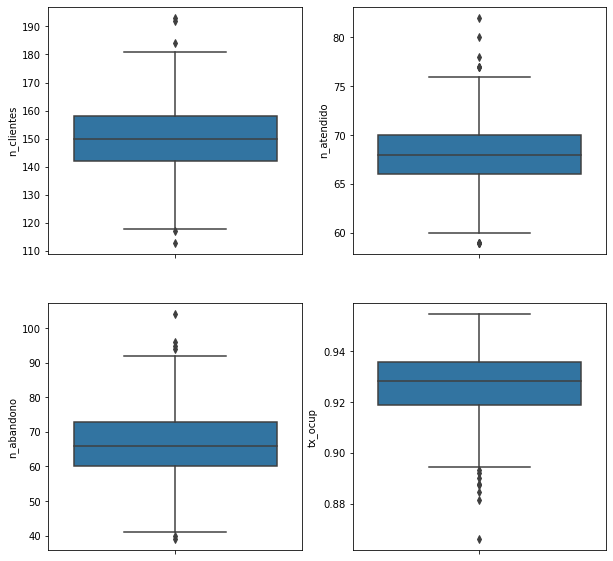

In [11]:
tb_resultados = pd.DataFrame(lista_resultados, columns = ['n_clientes', 'n_atendido', 'n_abandono', 'tx_ocup', 'tam_balcao'])
fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.boxplot(data = tb_resultados, y = 'n_clientes', ax = ax[0][0])
sns.boxplot(data = tb_resultados, y = 'n_atendido', ax = ax[0][1])
sns.boxplot(data = tb_resultados, y = 'n_abandono', ax = ax[1][0])
sns.boxplot(data = tb_resultados, y = 'tx_ocup', ax = ax[1][1])


In [16]:
lista_balcoes = [10] * 500 + [15] * 500 + [20] * 500 + [25] * 500 + [30] * 500
lista_balcoes[490:501]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15]

In [19]:
pool = Pool(processes=cpu_count() - 1)
lista_balcoes = [10] * 500 + [15] * 500 + [20] * 500 + [25] * 500 + [30] * 500 +  [35] * 500
lista_resultados = pool.map(simular_bar, lista_balcoes)

<AxesSubplot:xlabel='tam_balcao', ylabel='tx_ocup'>

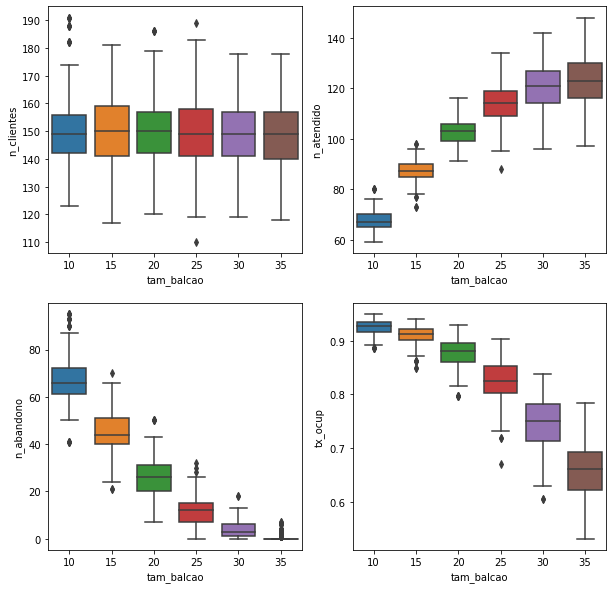

In [20]:
tb_resultados = pd.DataFrame(lista_resultados, columns = ['n_clientes', 'n_atendido', 'n_abandono', 'tx_ocup', 'tam_balcao'])

fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.boxplot(data = tb_resultados, y = 'n_clientes', x = 'tam_balcao', ax = ax[0][0])
sns.boxplot(data = tb_resultados, y = 'n_atendido', x = 'tam_balcao', ax = ax[0][1])
sns.boxplot(data = tb_resultados, y = 'n_abandono', x = 'tam_balcao', ax = ax[1][0])
sns.boxplot(data = tb_resultados, y = 'tx_ocup', x = 'tam_balcao', ax = ax[1][1])


In [24]:
TM_BAR = 50
CUSTO_FIXO = 100000
CUSTO_OP = 1000/(365/12)
tb_resultados['rb_cliente_atendido'] = tb_resultados['n_atendido'] * TM_BAR
tb_resultados['rl_cliente_atendido'] = tb_resultados['rb_cliente_atendido'] - CUSTO_OP*tb_resultados['tam_balcao']


<AxesSubplot:xlabel='tam_balcao', ylabel='rl_cliente_atendido'>

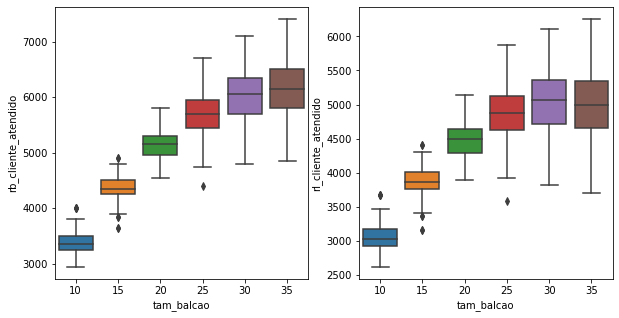

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(data = tb_resultados, y = 'rb_cliente_atendido', x = 'tam_balcao', ax = ax[0])
sns.boxplot(data = tb_resultados, y = 'rl_cliente_atendido', x = 'tam_balcao', ax = ax[1])

# Case II - Planejamento de Plantio

**Você trabalha em uma indústria de sementes multi-nacional e foi encarregado de estimar o risco da produção de sementes de uma variedade específica para safra 2023.**

A última etapa da produção de sementes é terceirizada: as diferentes variedades são enviadas para fazendeiros, que realizam o plantio, multiplicação e colheita do produto final.

Todo ano é necessário **alocar a produção das diferentes variedades entre os diferentes produtores**. Infelizmente, a **produção agrícola é repleta de riscos** - o que leva a produção de sementes a ser, muitos anos, menor que a demanda por sementes!

O **time de agronomia trabalhou para construir estimativas** de risco de produção levando em conta fatores qualitativos (localização do produtor, capital por ha., capacidade técnica...). Os **riscos estimados por produtos contém as informações abaixo**:

- Média e desvio padrão da produtividade (em sacas de semente/ha);
- Risco de Perda (probabilidade de perder toda produção);
- Área Disponível para Plantio (em ha);

**A meta para Safra de 2023 é 2000 Sacas de Semente de Soja**.

Você foi encarregado de simular diferentes cenários para diferentes alocações de produção e calcular o risco associado a cada cenário - precisamos saber qual a **probabilidade de cada alocação produzir 20% a mais ou a menos que a meta** (2000 sacas).

In [ ]:
produtor_a = [25, 2, 0.05, 5]
produtor_b = [40, 15, 0.1, 25]
produtor_c = [12, 1, 0.005, 50]
produtor_d = [50, 3, 0.15, 30]
produtores = [produtor_a, produtor_b, produtor_c, produtor_d]
tb_produtores = pd.DataFrame(produtores, columns=['mu_prod', 'sd_prod', 'per_perda', 'area_disp'])
tb_produtores

In [ ]:
cenario_a = [5, 20, 5, 20]
cenario_b = [1, 25, 50, 8]
cenario_c = [3, 22, 40, 12]
cenario_d = [2, 15, 50, 15]
cenarios = [cenario_a, cenario_b, cenario_c, cenario_d]
tb_cenarios = pd.DataFrame(cenarios, columns = ['aloc_A', 'aloc_B', 'aloc_C', 'aloc_D'])
tb_cenarios

In [ ]:
# SEU CÓDIGO AQUI!

## Desafio

Encontre a alocação com menor risco possível, respeitando o limite de produtividade de cada agricultor.

In [ ]:
# SEU CÓDIGO AQUI!